In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import seaborn as sns
import shap
import mca
import xgboost as xgb

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# 大まかにデータ見る

In [4]:
print(df.info())
df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
89,90,0,3,"Celotti, Mr. Francesco",male,24.0,0,0,343275,8.0500,NaN,S
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S
189,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S


In [5]:
# 使いそうなデータだけ取り出す。
new_df = df[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]

In [6]:
new_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
new_df = new_df.replace({"Sex":{"male":0,"female":1}})

# nanを埋める

In [8]:
new_df['Age']=new_df['Age'].fillna(new_df['Age'].median())

In [9]:
new_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
new_df['Embarked'] = new_df['Embarked'].fillna('S')

In [11]:
new_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [12]:
dummy_df = pd.get_dummies(new_df)

In [13]:
# dummy_df = preprocessing(new_df)

# データの描写
## MCA: Multiple Correspondence Analysis (mca)
主成分分析の質的変数版  

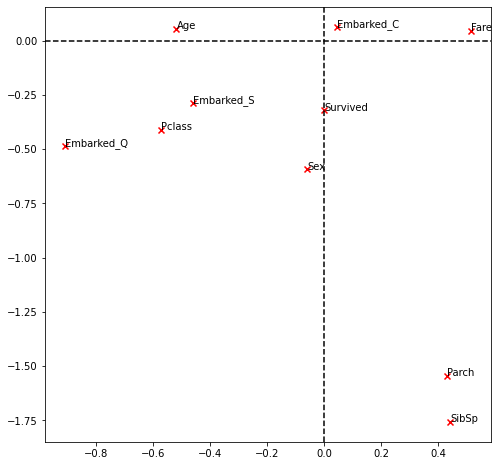

In [14]:
mca_counts = mca.MCA(dummy_df, benzecri=False)

rows = mca_counts.fs_r(N=2)
cols = mca_counts.fs_c(N=2)
"""
plt.scatter(rows[:,0], rows[:,1], c='b',marker='o')
labels = dummy_df.index
for label,x,y in zip(labels,rows[:,0],rows[:,1]):
    plt.annotate(label,xy = (x, y))
"""
plt.figure(figsize=(8,8))
plt.axvline(x=0, linestyle='--', color='k')
plt.axhline(y=0, linestyle='--', color='k')

plt.scatter(cols[:,0], cols[:,1], c='r',marker='x')
labels = dummy_df.columns
for label,x,y in zip(labels,cols[:,0],cols[:,1]):
    plt.annotate(label,xy = (x, y))
plt.show()

<AxesSubplot:xlabel='Survived', ylabel='count'>

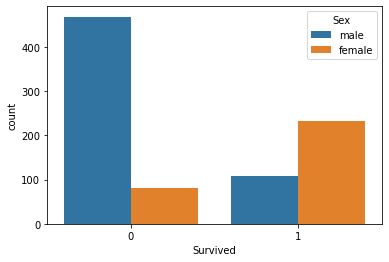

In [15]:
sns.countplot(x='Survived', hue ='Sex', data=df)

maleはよく死んでる

<AxesSubplot:xlabel='Survived', ylabel='count'>

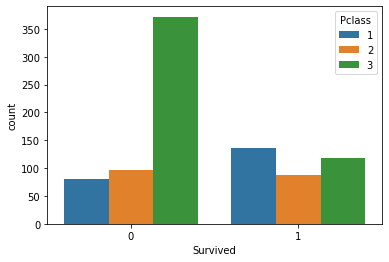

In [16]:
sns.countplot(x='Survived', hue='Pclass',data=df)

Pclassが3の人はおおく死んでる

<AxesSubplot:xlabel='Survived', ylabel='count'>

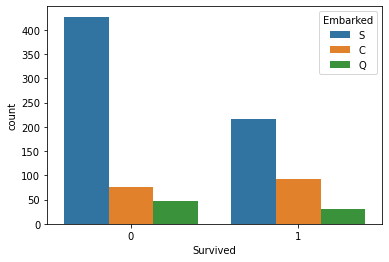

In [17]:
sns.countplot(x='Survived', hue='Embarked',data=df)

Sの人は多く死んでる

<AxesSubplot:xlabel='Pclass', ylabel='count'>

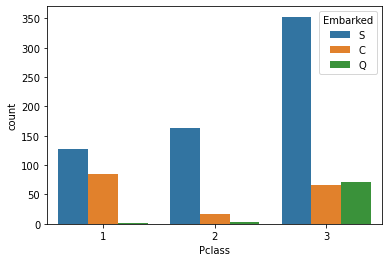

In [18]:
sns.countplot(x='Pclass', hue='Embarked',data=df)

pclassとembarkedには相関がありそう

<AxesSubplot:xlabel='Survived', ylabel='count'>

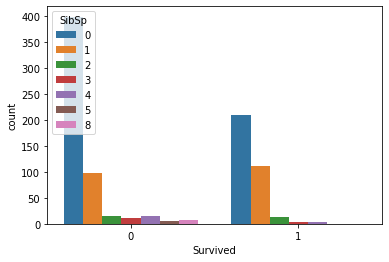

In [19]:
sns.countplot(x='Survived', hue='SibSp',data=df)

## カイ二乗検定

# 学習

In [20]:
test_df = pd.read_csv('test.csv')
test_df = test_df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
test_df['Age']= test_df['Age'].fillna(test_df['Age'].median())
test_df['Embarked'] = test_df['Embarked'].fillna('S')
print(test_df.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64


In [21]:
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

In [22]:
test_X = pd.get_dummies(test_df)

In [23]:
X_df = dummy_df.drop(columns=['Survived'])
y_s = dummy_df['Survived']

In [24]:
X_train_df, X_test_df, y_train_s, y_test_s = train_test_split(
    X_df, y_s, test_size=0.2, random_state=0, stratify=y_s
    )

## random forestを使用してみた

In [25]:
rf = RandomForestClassifier(max_depth=40, n_estimators=50, random_state=42)
rf.fit(X_train_df,y_train_s)

RandomForestClassifier(max_depth=40, n_estimators=50, random_state=42)

In [26]:
y_pred = rf.predict(X_test_df)
accuracy_score(y_pred=y_pred,y_true=y_test_s)

0.7821229050279329

### 各特長量のimportance

## random forest

In [27]:
importance = {}

for n, v in zip(X_train_df, rf.feature_importances_):
    importance[n] = v
importance = sorted(importance.items(), key=lambda x:x[1], reverse=True)
for i in importance:
    print(i)

('Sex', 0.28101946720889537)
('Fare', 0.25677703590639556)
('Age', 0.24340663511745844)
('Pclass', 0.09800466648668771)
('SibSp', 0.04932862819156063)
('Parch', 0.039776315369540655)
('Embarked_C', 0.012445833827763177)
('Embarked_S', 0.011473506963950436)
('Embarked_Q', 0.007767910927748047)


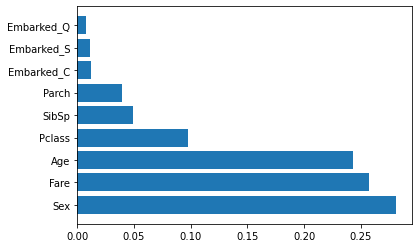

In [28]:
importance = dict(importance)
plt.barh(range(len(importance)), list(importance.values()), align='center')
plt.yticks(range(len(importance)), importance.keys())
plt.show()

### shap使ってみる
https://github.com/slundberg/shap

model_output = "margin" has been renamed to model_output = "raw"


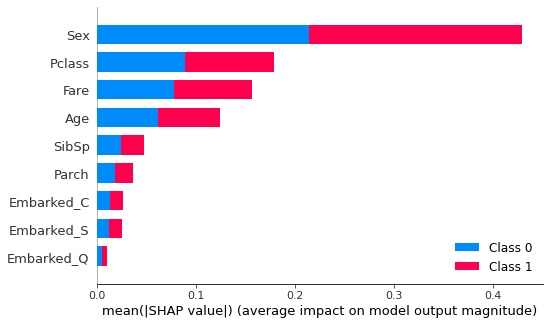

In [29]:
shap.initjs()
rf_explainer = shap.TreeExplainer(model=rf, feature_perturbation='tree_path_dependent',
                              model_output='margin')

# shap値
rf_shap_values = rf_explainer.shap_values(X=X_train_df)

# plot
shap.summary_plot(rf_shap_values, X_train_df, plot_type="bar")

## SVCを試した

In [30]:
svc = SVC()
svc.fit(X_train_df,y_train_s)
y_pred = svc.predict(X_test_df)
accuracy_score(y_pred=y_pred,y_true=y_test_s)

0.6312849162011173

## XGBboost

In [31]:
# xgboostの形に変形
dtrain = xgb.DMatrix(X_train_df, label=y_train_s)

In [32]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'multi:softmax', 'num_class': 2}

In [33]:
# 学習回数を決める
num_round = 10

# 学習させる
bst = xgb.train(param, dtrain, num_round)

[00:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
# accuracy求める

dtest = xgb.DMatrix(X_test_df)
y_pred = bst.predict(dtest)
accuracy_score(y_pred=y_pred,y_true=y_test_s)

0.7932960893854749

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

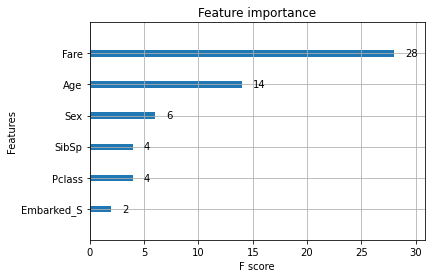

In [35]:
xgb.plot_importance(bst)

xgboostに対してshap使うとエラーが起きる  
Setting feature_perturbation = "tree_path_dependent" because no background data was given.　　
  
shapのバージョンを更新する  
https://github.com/slundberg/shap/issues/1215

model_output = "margin" has been renamed to model_output = "raw"


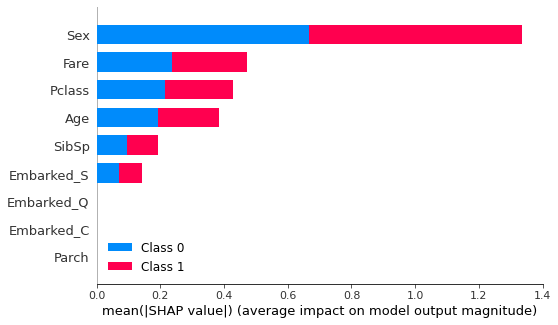

In [36]:
xgb_explainer = shap.TreeExplainer(model= bst, feature_perturbation='tree_path_dependent', model_output='margin')
xgb_shap_values = xgb_explainer.shap_values(X=X_train_df)
shap.summary_plot(xgb_shap_values, X_train_df, plot_type="bar")

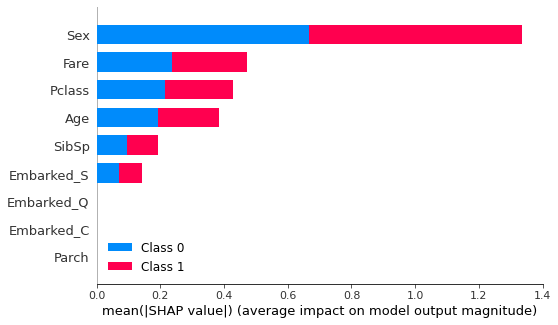

In [37]:
shap.summary_plot(xgb_shap_values, X_train_df)